In [1]:
import sys
import os

SCRIPT_DIR = os.path.dirname(os.path.abspath(os.getcwd()))
sys.path.append(SCRIPT_DIR)

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import pickle

from tueplots import bundles

from bocpd import bocpd
from hazard import ConstantHazard
from models import DSMGaussianSampling
from plot import plot_posterior

from sklearn import preprocessing

In [2]:
DATA_PATH = os.path.join(SCRIPT_DIR,'data/well-log')
RESULT_PATH = os.path.join(SCRIPT_DIR,'notebooks/results/well-log')
FILE_PATH = os.path.join(DATA_PATH,'well.txt')

In [3]:
data = np.loadtxt(FILE_PATH)
T=len(data)
data = data.reshape([T,1])

In [4]:
data_scaled = preprocessing.StandardScaler().fit_transform(data)

In [5]:
def m(x):
    return np.asarray([(1+x**2)**(-1/2)])

def grad_m(x):
    return np.asarray([[-x/((1+x**2)**(3/2))]])

def grad_t(x):
    return np.asarray([[1,-x]],dtype='float')

def grad_b(x):
    return np.asarray([[0]])

def hess_t(x):
    return np.asarray([[[0,-1]]])

beta = 0.0003

mean_mu0 = 0
var_mu0 = 0.1

mean_Sigma0 = 1
var_Sigma0 = 0.01

mu0 = np.array([[mean_mu0/var_mu0], [1/var_mu0]])

Sigma0 = np.eye(2)
Sigma0[0,0] = mean_Sigma0/var_Sigma0
Sigma0[1,1] = 1/var_Sigma0


model = DSMGaussianSampling(data_scaled, m ,grad_m, grad_t, hess_t, grad_b, beta, mu0, Sigma0, b = 20)

In [6]:
from beta_estimator import BetaEstimatorFisher
estimator = BetaEstimatorFisher(data_scaled[100:500], m, grad_m, grad_t, hess_t, grad_b, mu0, Sigma0, p = 2, d = 1, B = 100)

In [7]:
hazard = ConstantHazard(100)

In [8]:
%%time
np.random.seed(100)
R_DSM_sampling  = bocpd(data_scaled, hazard, model, K=50, verbose=True)

Processing observation #100
Processing observation #200
Processing observation #300
Processing observation #400
Processing observation #500
Processing observation #600
Processing observation #700
Processing observation #800
Processing observation #900
Processing observation #1000
Processing observation #1100
Processing observation #1200
Processing observation #1300
Processing observation #1400
Processing observation #1500
Processing observation #1600
Processing observation #1700
Processing observation #1800
Processing observation #1900
Processing observation #2000
Processing observation #2100
Processing observation #2200
Processing observation #2300
Processing observation #2400
Processing observation #2500
Processing observation #2600
Processing observation #2700
Processing observation #2800
Processing observation #2900
Processing observation #3000
Processing observation #3100
Processing observation #3200
Processing observation #3300
Processing observation #3400
Processing observation 

In [9]:
def find_CPs(R, lag = 20):
    n = len(R)
    CPs = [0]
    last_CP = 0
    for i in range(n):
        candidate = i-np.argmax(R[i,:])
        if candidate > last_CP+lag:
            if (candidate not in CPs):
                CPs.append(candidate)
                last_CP = np.max(CPs)
        if candidate < last_CP:
            try:
                CPs.remove(last_CP)
                last_CP = np.max(CPs)
            except:
                pass
    return CPs

In [10]:
cps_DSM_sampling = find_CPs(R_DSM_sampling)

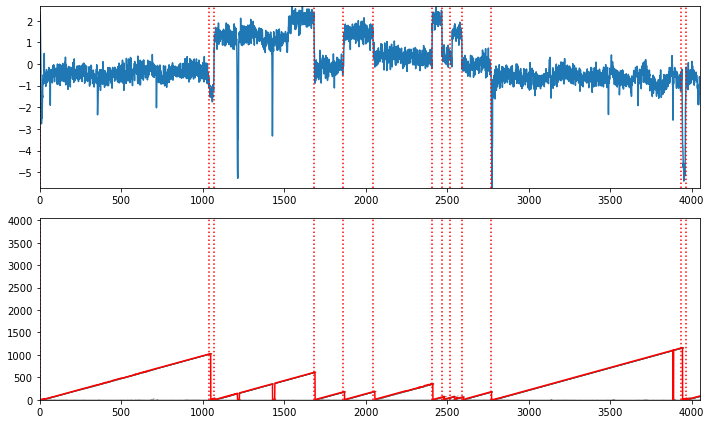

In [11]:
plot_posterior(T, data_scaled, R_DSM_sampling, cps_DSM_sampling)

In [12]:
with open(os.path.join(DATA_PATH,'BetaDivergence.pickle'), 'rb') as handle:
    result_beta = pickle.load(handle)

In [13]:
with open(os.path.join(DATA_PATH,'bocpd.pickle'), 'rb') as handle:
    result_bocp = pickle.load(handle)

In [14]:
R_bocp = np.zeros((T,T))
R_bocp[0,0] = 1
for i in range(T-1):
    R_bocp[i+1,result_bocp[14][i]] = np.exp(result_bocp[12][i])

In [15]:
cps_bocp = np.asarray(result_bocp[6][-2])[:,0]

In [16]:
R_beta = np.zeros((T,T))
R_beta[0,0] = 1
for i in range(T-1):
    R_beta[i+1,result_beta[14][i]] = np.exp(result_beta[12][i])

In [17]:
cps_beta = np.asarray(result_beta[6][-2])[:,0]

In [18]:
CB_color_cycle = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']

/tmp/ipykernel_27646/1800898386.py:37: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  fig.subplots_adjust(hspace=0)


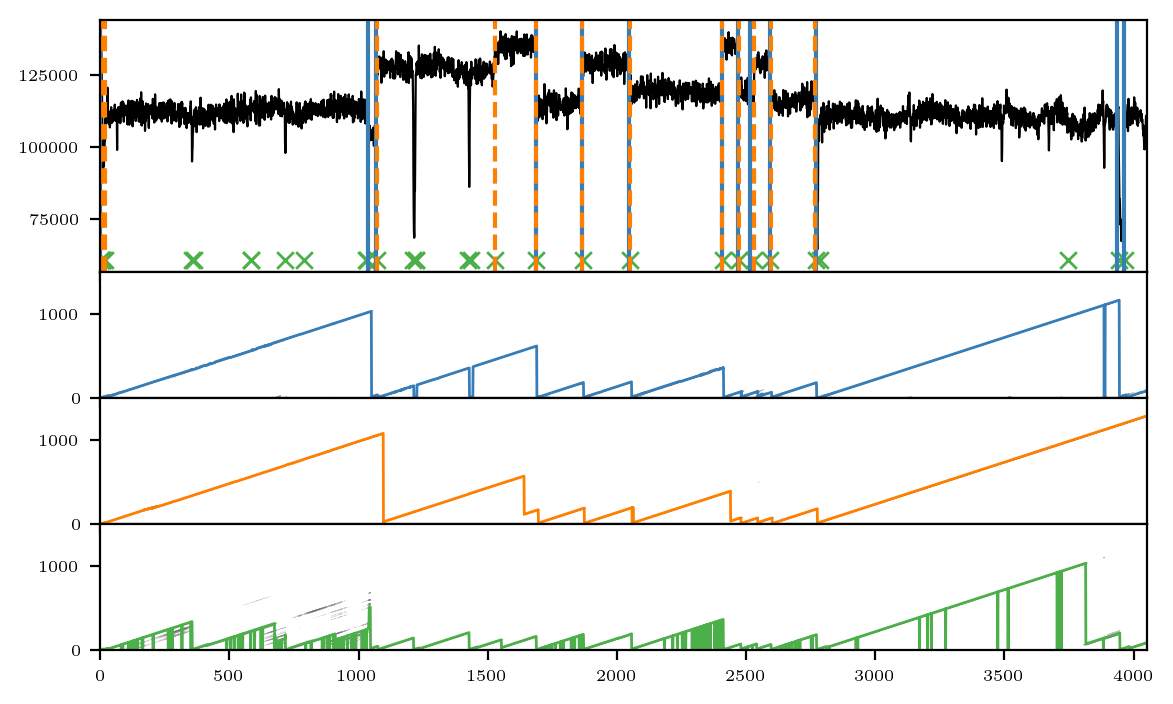

In [19]:
FILE_NAME = 'Well_full.pdf'
with plt.rc_context(bundles.icml2022(column='full', ncols=2, nrows=2)):

    fig, ax = plt.subplots(4, 1, sharex = True, gridspec_kw={'height_ratios': [2,1,1,1]}, dpi = 200)
    
    ax[0].set_xlim([0,T])
    ax[0].plot(data[:,0],c='black',lw=0.8)
    y_lims = ax[0].get_ylim()

    ax[1].set_xlim([0,T])
    ax[1].set_ylim([0,1500])
    ax[1].imshow(np.rot90(R_DSM_sampling), aspect='auto', cmap='gray_r', 
                   norm=LogNorm(vmin=0.0001, vmax=1), extent=[0,T,0,T])
    ax[1].plot(np.argmax(R_DSM_sampling,axis=1), c=CB_color_cycle[0], lw=1)
    
    ax[2].set_xlim([0,T])
    ax[2].set_ylim([0,1500])
    ax[2].imshow(np.rot90(R_beta), aspect='auto', cmap='gray_r', 
                   norm=LogNorm(vmin=0.0001, vmax=1), extent=[0,T,0,T])
    ax[2].plot(np.argmax(R_beta,axis=1), c=CB_color_cycle[1], lw=1)
    
    ax[3].set_xlim([0,T])
    ax[3].set_ylim([0,1500])
    ax[3].imshow(np.rot90(R_bocp), aspect='auto', cmap='gray_r', 
                   norm=LogNorm(vmin=0.0001, vmax=1), extent=[0,T,0,T])
    ax[3].plot(np.argmax(R_bocp,axis=1), c=CB_color_cycle[2], lw=1)
    
    for cp in cps_DSM_sampling:
        ax[0].axvline(cp, c=CB_color_cycle[0], lw=1.5)
        
    for cp in cps_beta:
        ax[0].axvline(cp, c=CB_color_cycle[1], ls='dashed', lw=1.5)
        
    for cp in cps_bocp:
        ax[0].scatter(cp, y_lims[0], marker='x', c=CB_color_cycle[2],alpha=1, lw=1)
        
    fig.subplots_adjust(hspace=0)
    fig.savefig(os.path.join(RESULT_PATH, FILE_NAME), format="pdf", bbox_inches= "tight")